In [1]:
#Define functions (Always run)

import pandas as pd
import numpy as np
from os import listdir
from os.path import getmtime
import subprocess

#Import only the parameters from the file
def read_params(filename = None):
    #If no filename is given, read the last .dat file
    if filename == None:
        #Animate a file
        last_date = 0
        dat_files = listdir()
        for f in dat_files:
            if f.endswith('.dat'):
                date = getmtime(f)
                if date > last_date:
                    last_date = date
                    filename = f

    #Open file and read the first lines
    data = open(filename)
    text = ''
    params = {}

    params1 = ['metric','fType']
    for i in range(len(params1)):
        row   = data.readline()
        text += row
        params.update({params1[i]:row.split(':')[1][1:-1]})
    params2 = ['p0','r0','d','deltaR','maxR','BH radius','BH mass']
    for i in range(len(params2)):
        row   = data.readline()
        text += row
        try:
            value = float(row.split(':')[1])
        except:
            value = -9999
        params.update({params2[i]:value})
    params3 = ['iterations','nP','time']
    for i in range(len(params3)):
        row   = data.readline()
        text += row
        params.update({params3[i]:int(row.split(':')[1])})
    params.update({'text':text[:-1]})

    return params

#Import the data from the file
def read_data(filename = None):
    #If no filename is given, read the last .dat file
    if filename == None:
        #Animate a file
        last_date = 0
        dat_files = listdir()
        for f in dat_files:
            if f.endswith('.dat'):
                date = getmtime(f)
                if date > last_date:
                    last_date = date
                    filename = f

    #Open file and read the first lines
    data = open(filename)
    params = read_params(filename)
    for _ in range(len(params['text'].splitlines())):
        data.readline()

    #Read data for R, phi, Phi and Pi
    rdata = list(map(float,(data.readline().split(','))[:-1]))
    alldata = data.readlines()
    data.close()
    len_6 = int(len(alldata)/6)
    if(len_6*6 !=len(alldata)):
        raise ValueError

    for i in range(6*len_6):
        alldata[i] = list(map(float,(alldata[i].replace('-nan(ind)','nan').split(','))[:-1]))
    fdata = np.array(alldata[:len_6])
    mdata = np.array(alldata[len_6:2*len_6])
    xdata = np.array(alldata[2*len_6:3*len_6])
    ydata = np.array(alldata[3*len_6:4*len_6])
    if(params['metric'].startswith('Modified Choptuik')):
        grdata = (np.array(alldata[4*len_6:5*len_6]))**2
        g0data = (np.array(alldata[5*len_6:]))**2
    elif(params['metric'].startswith('Modified Choptuik2')):
        grdata = (np.array(alldata[4*len_6:5*len_6]))**2
        g0data = (np.array(alldata[5*len_6:])+1)**2
    else:
        grdata = (np.array(alldata[4*len_6:5*len_6]))**(-2)
        g0data = (np.array(alldata[5*len_6:]))#**(-2)

    return rdata, fdata, xdata, ydata, grdata, g0data, mdata, params

def read_binaries(a_bin='A.bin',Phi_bin='Phi.bin',R_bin='R.bin'):
    params = {'text':'text pending'}
    with open(Phi_bin,'rb') as file:
        xdata = np.fromfile(file, dtype=np.float64)
    with open(a_bin,'rb') as file:
        grdata = np.fromfile(file, dtype=np.float64)**(-2)
    with open(R_bin,'rb') as file:
        rdata = np.fromfile(file, dtype=np.float64)
    iterations = int(len(xdata)/len(rdata))
    xdata = xdata.reshape((iterations,len(rdata)))
    grdata = grdata.reshape((iterations,len(rdata)))
    fdata = np.zeros_like(xdata)
    ydata = np.zeros_like(xdata)
    g0data = np.zeros_like(xdata)
    fdata[0] = 1
    return rdata, fdata, xdata, ydata, grdata, g0data, params
import matplotlib.animation as animation
import matplotlib.pyplot as plt


def read_binaries(a_bin='A.bin',Phi_bin='Phi.bin',R_bin='R.bin'):
    params = {'text':'text pending'}
    with open(Phi_bin,'rb') as file:
        xdata = np.fromfile(file, dtype=np.float64)
    with open(a_bin,'rb') as file:
        grdata = np.fromfile(file, dtype=np.float64)**(-2)
    with open(R_bin,'rb') as file:
        rdata = np.fromfile(file, dtype=np.float64)
    iterations = int(len(xdata)/len(rdata))
    xdata = xdata.reshape((iterations,len(rdata)))
    grdata = grdata.reshape((iterations,len(rdata)))
    fdata = np.zeros_like(xdata)
    ydata = np.zeros_like(xdata)
    g0data = np.zeros_like(xdata)
    fdata[0] = 1
    return rdata, fdata, xdata, ydata, grdata, g0data, params
import matplotlib.animation as animation
import matplotlib.pyplot as plt

#Animation in paralel of scalar fields
def animate_data(filename = None, ipf = 1,output_name = None,ls='-',marker='',ms=0.5,ftype='dat',dpi=120):
    if ftype=='dat':
        r,f,x,y,gr,g0,m,params = read_data(filename)
    elif ftype=='bin':
        r,f,x,y,gr,g0,m,params = read_binaries()
    else:
        raise ValueError

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(f)
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(3,2,figsize=(12,12),dpi=dpi)

    #Plot data at the first iteration
    Fplot = ax[0,0].plot(r,f[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Mplot = ax[0,1].plot(r,m[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Xplot = ax[1,0].plot(r,x[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Yplot = ax[2,0].plot(r,y[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Aplot = ax[1,1].plot(r,gr[0],ls=ls,marker=marker,markersize=ms)[0]
    Bplot = ax[2,1].plot(r,g0[0],ls=ls,marker=marker,markersize=ms)[0]
    ax[1,0].set_ylim( -3*ax[1,0].get_ylim()[1],3*ax[1,0].get_ylim()[1])
    ax[2,0].set_ylim(  ax[1,0].get_ylim())
    ax[1,1].set_ylim(-0.1,1.1)
    ax[2,1].set_ylim(-0.1,1.1)

    #Set up text
    #ax[0,1].remove()
    #ax[0,0].text(1.21,0.98,params['text'],verticalalignment='top',transform=ax[0,0].transAxes)
    text = params['text'].splitlines()
    text1 = text[:len(text)//2]
    text2 = text[len(text)//2:]
    text1 = '\n'.join(text1)
    text2 = '\n'.join(text2)
    ax[0,0].text(0.95,1.1,text1,verticalalignment='bottom',horizontalalignment='right',transform=ax[0,0].transAxes)
    ax[0,0].text(1.05,1.1,text2,verticalalignment='bottom',horizontalalignment='left',transform=ax[0,0].transAxes)
    

    #Make limits for phi plot based on maximum initial difference from external point
    #try:
    #    deltaLim = max(m[0][-1] -ax[0,0].get_ylim()[0], ax[0,0].get_ylim()[1] -m[0][-1])
    #    ax[0,0].set_ylim(f[0][-1]-deltaLim,f[0][-1]+deltaLim)
    #except:
    #    None
    ax[0,0].set_title('$\phi$')
    ax[1,0].set_title('$\Phi$')
    ax[2,0].set_title('$\Pi$')
    ax[0,1].set_title('$M$')
    ax[1,1].set_title('$g^{rr}$')
    ax[2,1].set_title('$g^{00}$')

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        Fplot.set_data(r,f[it])
        Mplot.set_data(r,m[it])
        Xplot.set_data(r,x[it])
        Yplot.set_data(r,y[it])
        Aplot.set_data(r,gr[it])
        Bplot.set_data(r,g0[it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)
    if (filename == None):
        filename = 'Output.dat'
    if (output_name == None):
        output_name = filename[:-3]+'gif'
    anim.save(output_name,writer='pillow')
    plt.close()


def plot_last(filename = None, diff_from_collapse=-1, replace_nan=-1):
    r,f,x,y,gr,g0,m,params = read_data(filename)


    iterations = len(f)

    #Find the last iteration before collapse
    last_iteration = iterations-1
    for i in range(iterations):
        f_nan  = np.any(np.isnan( f[i]))
        #f_nan  = False
        x_nan  = np.any(np.isnan( x[i]))
        y_nan  = np.any(np.isnan( y[i]))
        gr_nan = np.any(np.isnan(gr[i]))
        g0_nan = np.any(np.isnan(g0[i]))
        if np.any((f_nan,x_nan,y_nan,gr_nan,g0_nan)):
            last_iteration = i+diff_from_collapse
            break

    fig, ax = plt.subplots(3,2,figsize=(12,12),dpi=100)

    ax[0,0].plot(r,np.nan_to_num( f[last_iteration],nan=replace_nan))[0]
    ax[1,0].plot(r,np.nan_to_num( x[last_iteration],nan=replace_nan))[0]
    ax[2,0].plot(r,np.nan_to_num( y[last_iteration],nan=replace_nan))[0]
    ax[1,1].plot(r,np.nan_to_num(gr[last_iteration],nan=replace_nan))[0]
    ax[2,1].plot(r,np.nan_to_num(g0[last_iteration],nan=replace_nan))[0]
    ax[0,0].text(1.21,0.98,params['text']+f'\nPrinted iteration: {last_iteration}',verticalalignment='top',transform=ax[0,0].transAxes)
    ax[0,1].remove()
    #ax[1,1].set_ylim(-0.1,1.1)
    #ax[2,1].set_ylim(-0.1,1.1)
    ax[0,0].set_title('$\phi$')
    ax[1,0].set_title('$\Phi$')
    ax[2,0].set_title('$\Pi$')
    ax[1,1].set_title('$g^{rr}$')
    ax[2,1].set_title('$g^{00}$')

    plt.show()

#Animation in paralel of scalar fields
def animate_multiple(filenames, ipf = 1,output_name = None,ls='-',marker='',ms=0.5):
    Nfiles = len(filenames)
    r= []
    x= []
    params= []
    for iN,file in enumerate(filenames):
        r_,f_,x_,y_,gr_,g0_,params_ = read_data(file)
        r.append(r_)
        x.append(x_)
        params.append(params_)
    #r,f,x,y,gr,g0,params = read_binaries()

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(x[0])
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(Nfiles,1,figsize=(10,Nfiles*2),dpi=120)
    Xplot = []
    for iN in range(Nfiles):
        Xplot.append(ax[iN].plot(r[iN],x[iN][0] ,ls=ls,marker=marker,markersize=ms)[0])
        #ax[iN].text(1.21,0.98,params[iN]['text'],verticalalignment='top',transform=ax[iN].transAxes)
        ax[iN].set_title(f'$\Phi$\tKO coeff = {params[iN]["Kreiss-Oliger"]}')
    fig.tight_layout()

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        for iN in range(Nfiles):
            Xplot[iN].set_data(r[iN],x[iN][it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)
    if (output_name == None):
        output_name = 'Multi_anim.gif'
    anim.save(output_name,writer='pillow')
    plt.close()
        


In [2]:
#Animation of only alpha
def animate_alpha(filename = None, ipf = 1,output_name = None,ls='-',marker='',ms=0.5,ftype='dat'):
    if ftype=='dat':
        r,f,x,y,gr,g0,params = read_data(filename)
    elif ftype=='bin':
        r,f,x,y,gr,g0,params = read_binaries()
    else:
        raise ValueError

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(f)
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(1,figsize=(6,4),dpi=120)

    Bplot = ax.plot(r,g0[0],ls=ls,marker=marker,markersize=ms)[0]
    ax.set_ylim(-0.1,1.1)
    ax.set_title('$\\alpha$')

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        Bplot.set_data(r,g0[it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)
    if (output_name == None):
        output_name = filename[:-3]+'gif'
    anim.save(output_name,writer='pillow')
    plt.close()

# Random testing

In [3]:
#Arbitrary run

import subprocess
import numpy as np

fType = "1"
r0 = "0"
d  = "0"
ko  = "0.0"
deltaR = '0.01'
maxR = "50"
iterations = "20000"
p0 = '0.000005'

output = subprocess.check_output([".\VCollapse.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
print(f"{output}")

animate_data()

Total iterations: 20000
nR: 5001
nR_extended: 5017
dR_pointer: 0.010000
dT_pointer: 0.002000
grid range: 1.000000e-50 - 5.000000e+01

nR: 2501
nR_extended: 2517
dR_pointer: 0.010000
dT_pointer: 0.002000
grid range: 2.500000e+01 - 5.000000e+01

nR: 2501
nR_extended: 2517
dR_pointer: 0.005000
dT_pointer: 0.001000
grid range: 1.250000e+01 - 2.500000e+01

nR: 5001
nR_extended: 5017
dR_pointer: 0.002500
dT_pointer: 0.000500
grid range: 1.000000e-50 - 1.250000e+01

iteration start
Finished, total time: 300s



In [15]:
#Animate last file
animate_data()

In [ ]:
#Animate a file
dat_files = listdir()
dat_files = [f for f in dat_files if (f.startswith('Output') and f.endswith('.dat'))]
print('Índice  Nombre')
for i in range(len(dat_files)):
    print(f'{i}       {dat_files[i]}')
file_dat= input("Ingrese el índice o nombre del archivo que desea graficar: ")
if not file_dat.endswith('.dat'):
    file_dat = dat_files[int(file_dat)]

print(f'Graficando {file_dat} ...')
animate_data(file_dat,5,ls='',marker='.',ms=1)
#animate_alpha(file_dat,40,ms=1)
print(f'Animación de {file_dat} lista')
#plot_last(inlist_dat,0)

In [9]:
#Animate all files
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
        animate_data(file,ipf=10)
        print(f'Animation for {file} ready')

Animation for Output_201658.dat ready


In [ ]:
#Plot last frame of all files
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
        plot_last(file,0)

## Test on different parameters

In [26]:
#Run for tanh function

import subprocess
import numpy as np

fType = "0"
p0s = np.linspace(0.04,0.08,6)
r0 = "0"
d  = "0"
q  = "0"
iterations = "30000"
maxR = "50"
processes = "0"
for p0 in p0s:
    output = subprocess.check_output([".\Collapse.exe", fType, str(p0), r0, d, q, maxR, iterations, processes], text=True,)
    print(f"{output}")

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished



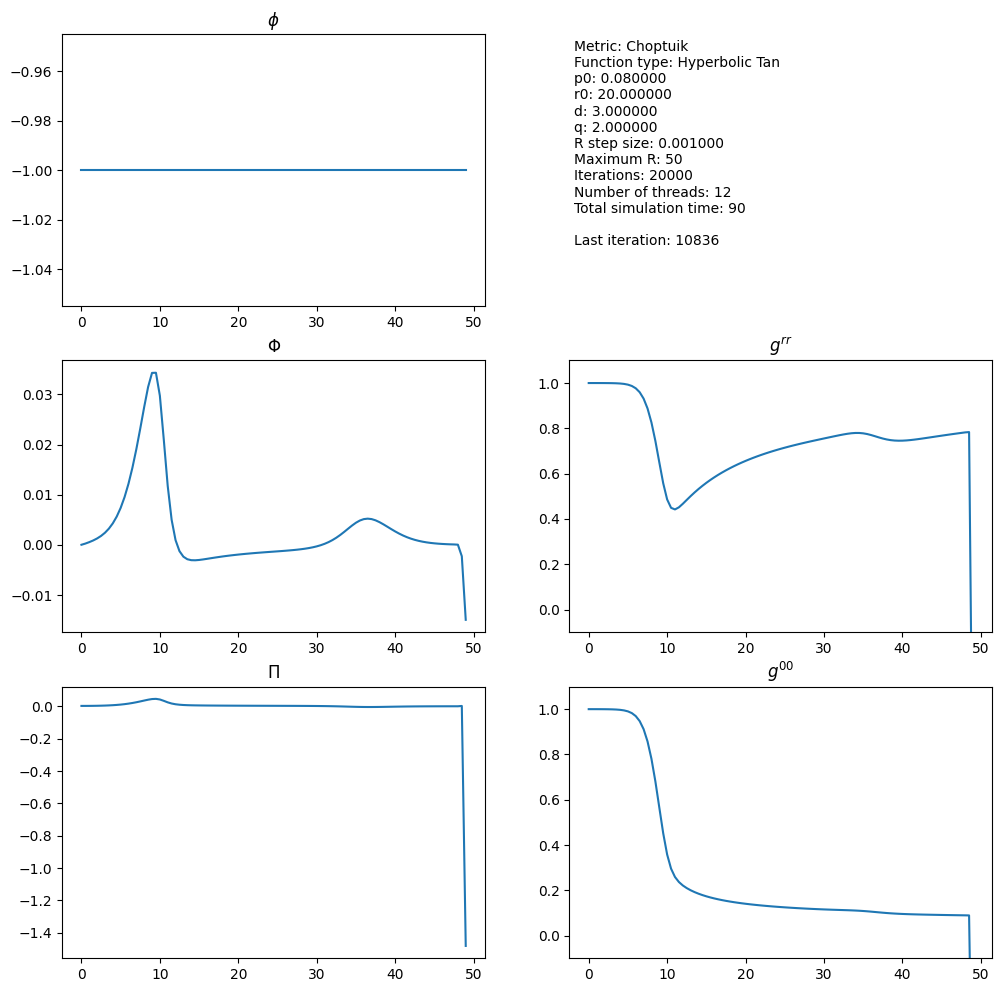

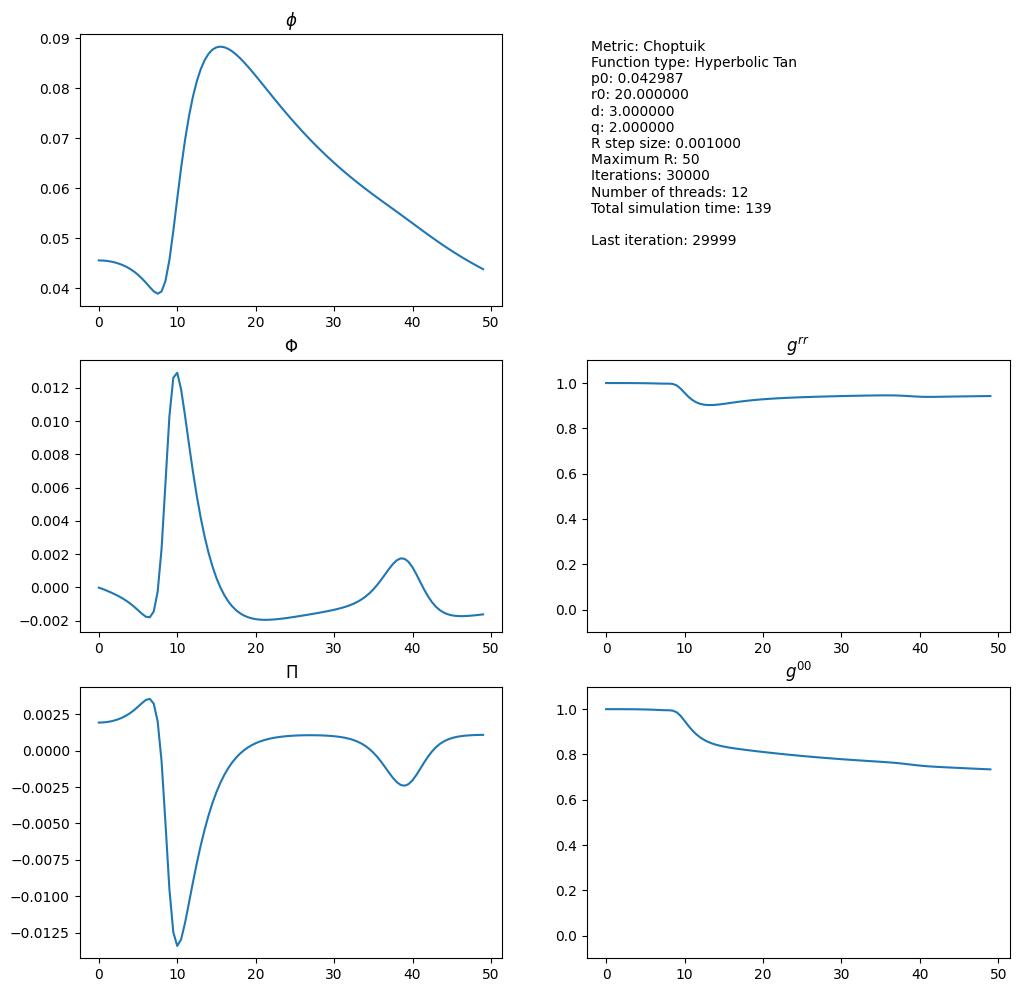

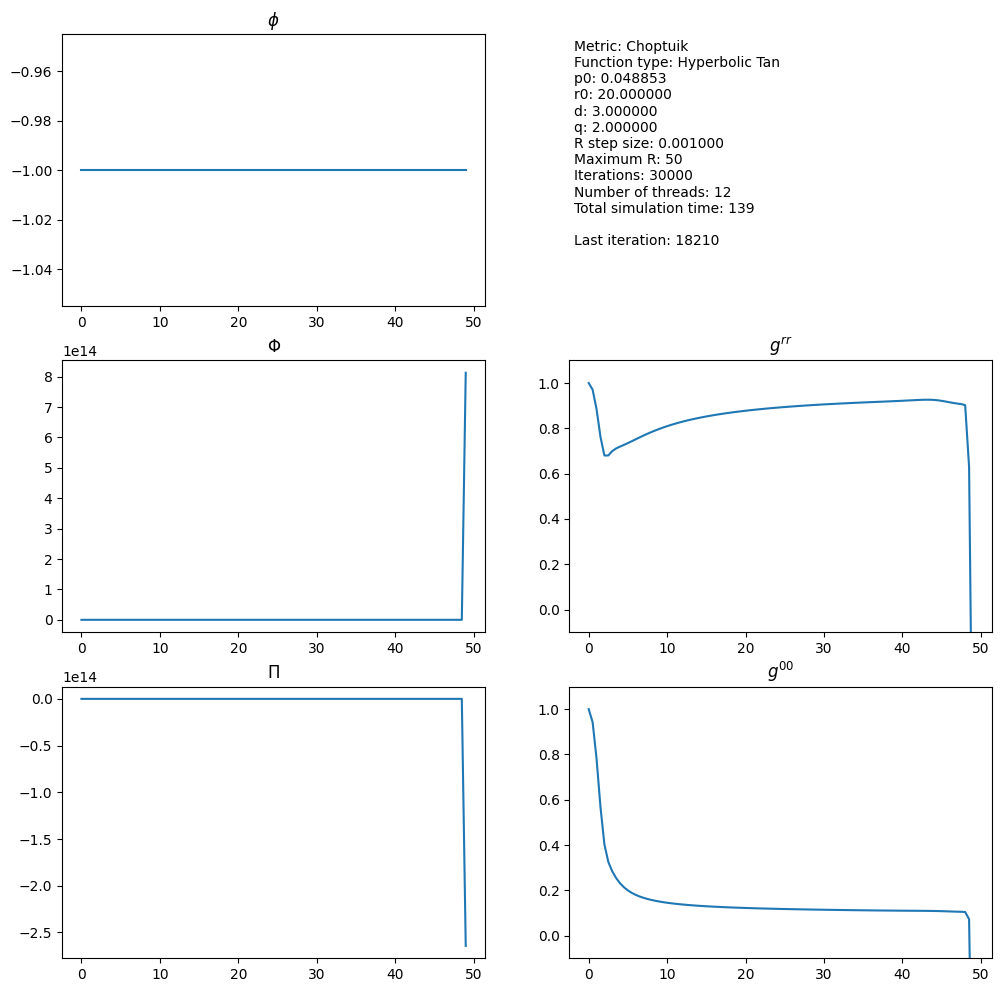

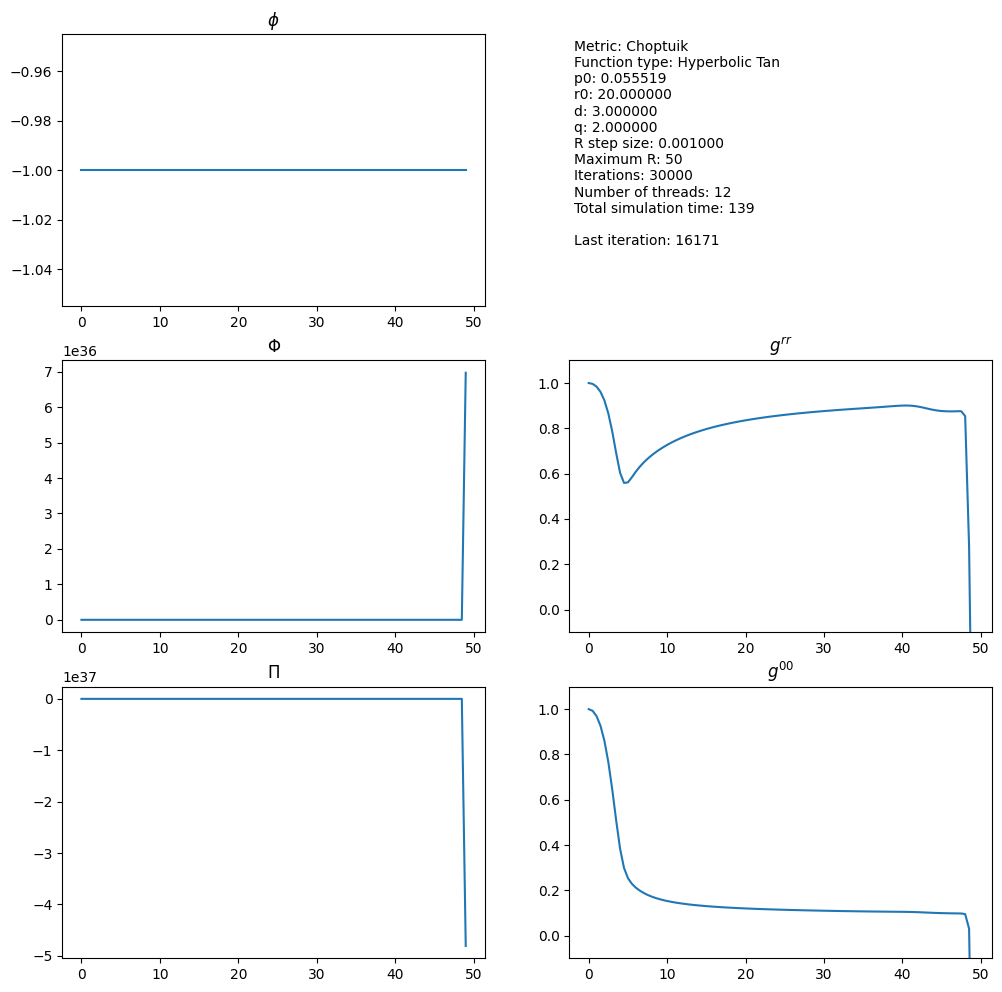

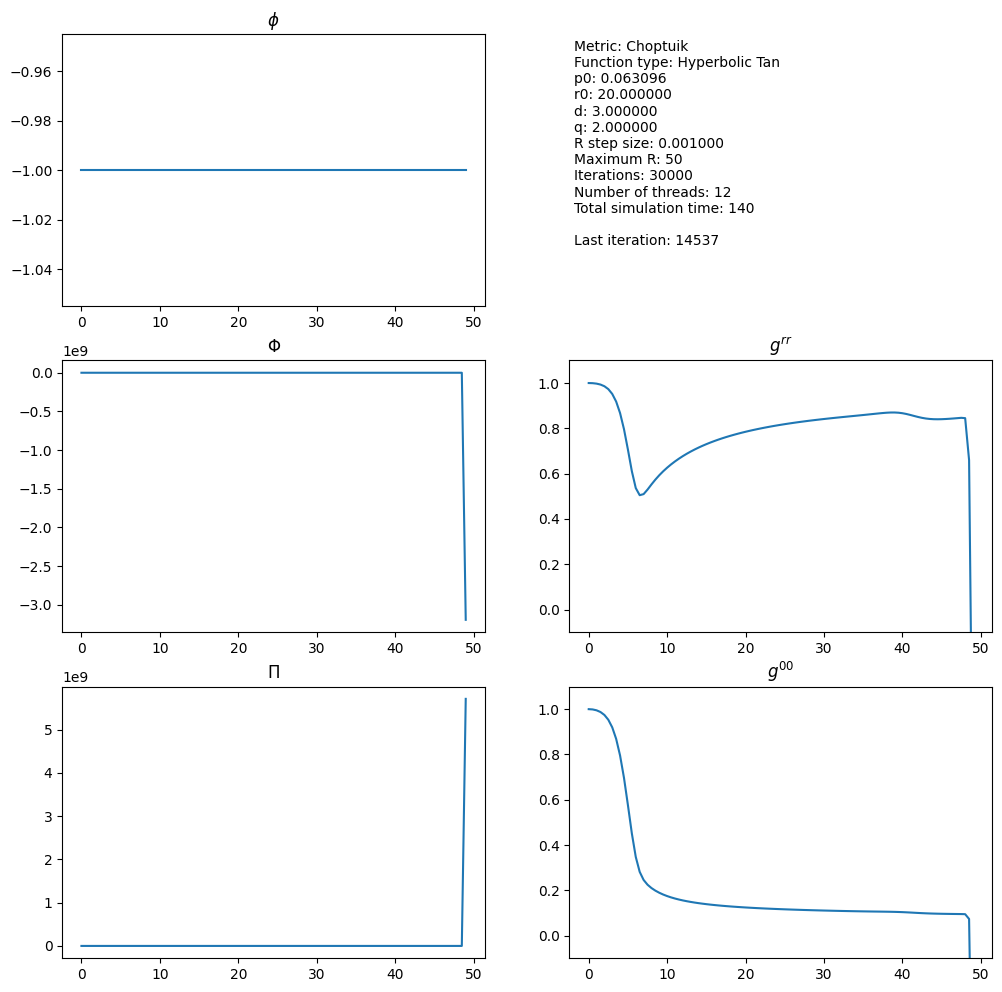

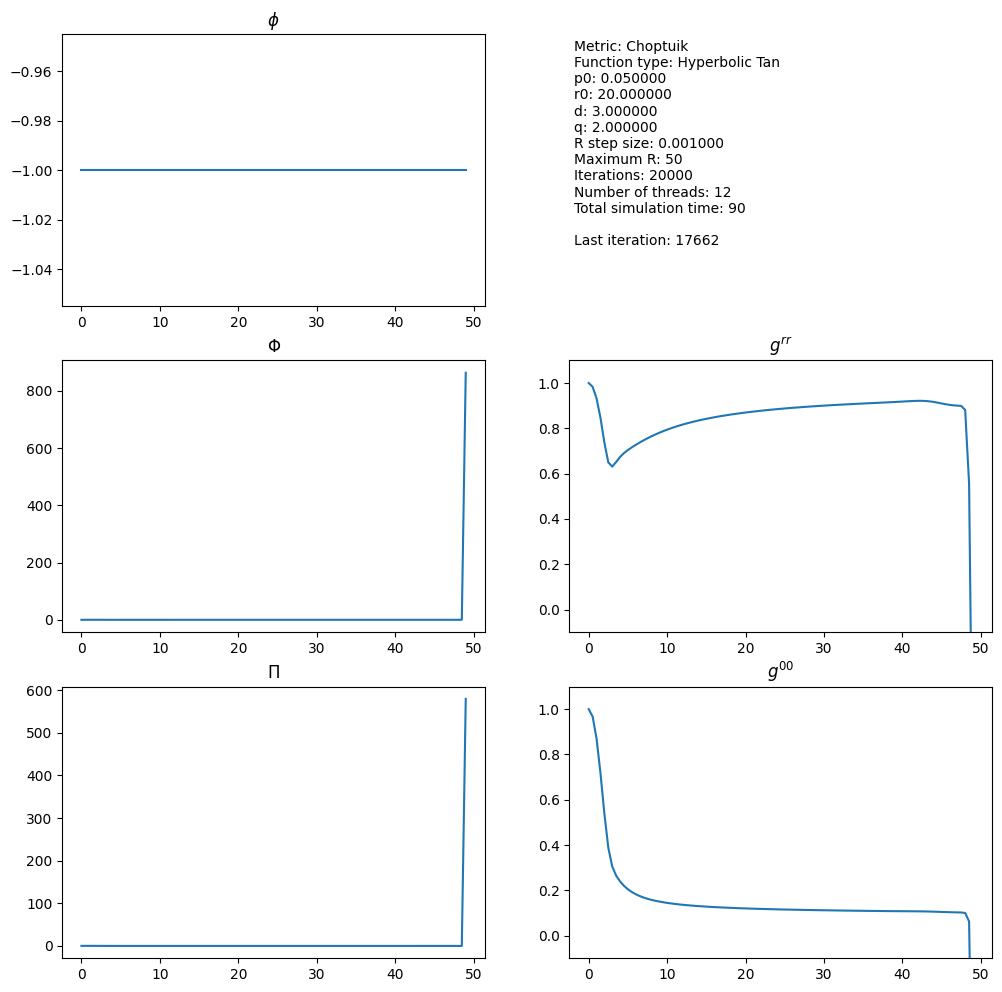

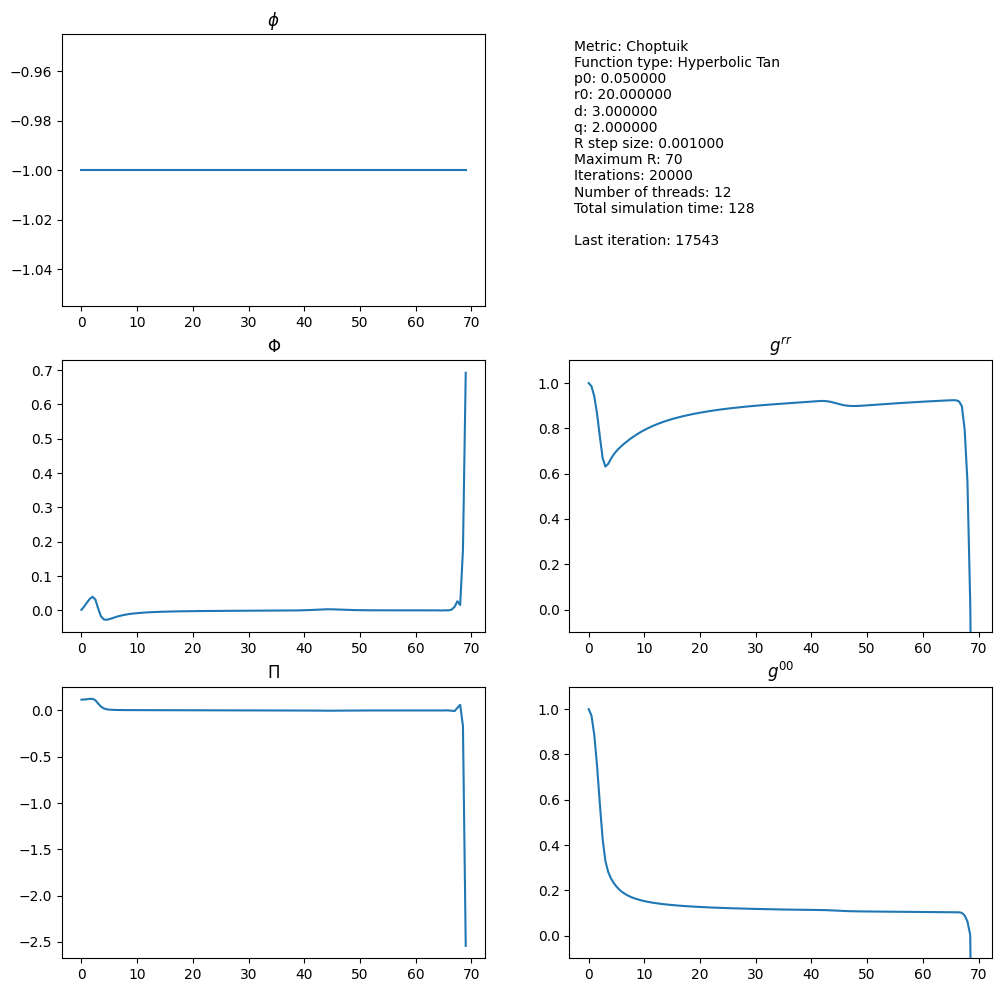

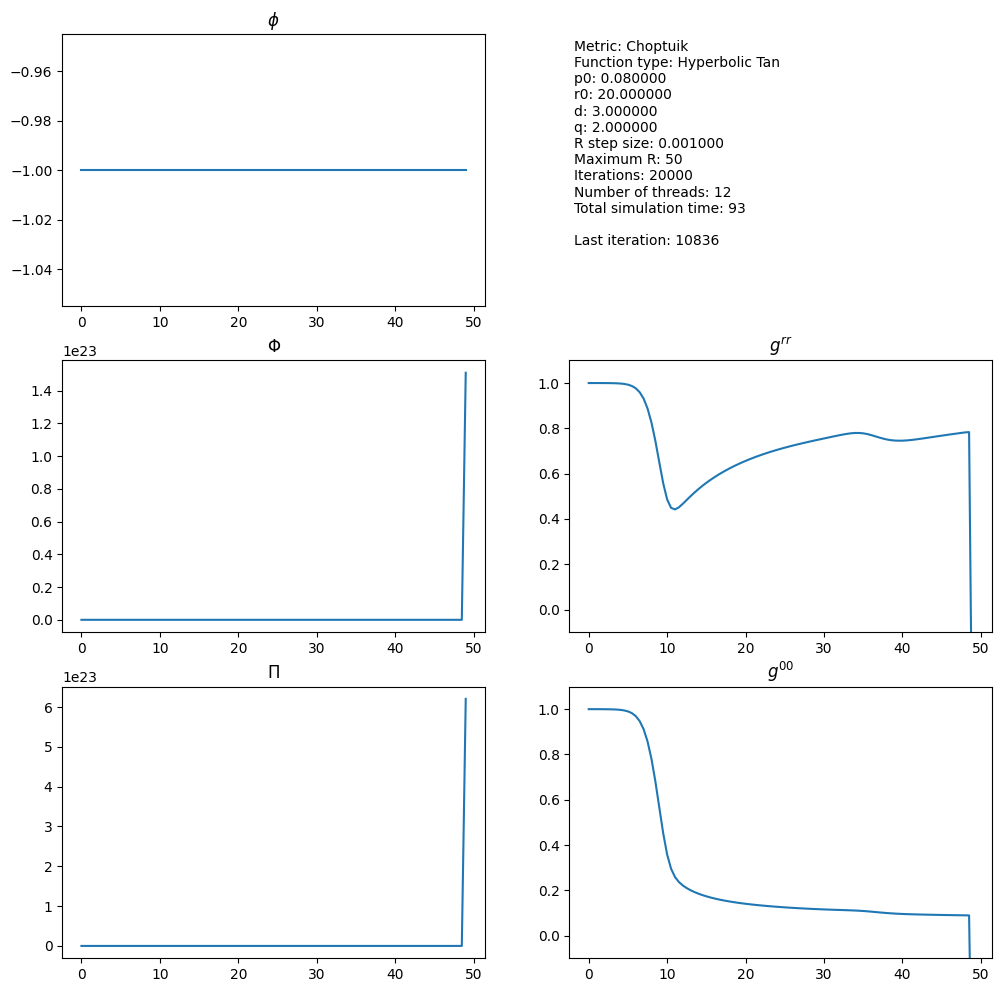

In [33]:
#Read the last runs and print the image before collapse
import pandas as pd
from os import listdir

#Search files
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
    r,f,x,y,a,b,param = read_data(file)
    if param['fType'] == 'Hyperbolic Tan':
        plot_last(file,0)
        plt.show()

In [5]:
#Run for exponential  function

import subprocess
import numpy as np

fType = "1"
p0s = np.array((3.7,5,6,8))*10**(-6)
r0 = "0"
d  = "0"
q  = "0"
iterations = "20000"
maxR = "50"
processes = "0"
for p0 in p0s:
    output = subprocess.check_output([".\Collapse_full.exe", fType, str(p0), r0, d, q, maxR, iterations, processes], text=True,)
    print(f"{output}")

Parallel execution:
Total iterations: 20000
Finished

Parallel execution:
Total iterations: 20000
Finished

Parallel execution:
Total iterations: 20000
Finished

Parallel execution:
Total iterations: 20000
Finished



In [1]:
#Read the last runs and print the image before collapse
import pandas as pd
from os import listdir

#Search files
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
    r,f,x,y,a,b,param = read_data(file)
    if param['fType'] == 'Exponential':
        plot_last(file,0)
        plt.show()

NameError: name 'read_data' is not defined

# Specific tests

## Minkowski test

In [4]:
# Test for gaussian curve

import subprocess
import numpy as np

fType = "1"
r0 = "0"
ds  = ["1","3","5"]
deltaR = '0.001'
maxR = "50"
iterations = "200000"
p0s = ['0.000001','0.000005','0.00001']

for d in ds:
    for p0 in p0s:
        output = subprocess.check_output([".\Collapse_minkowski.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")

Total iterations: 200000
Finished, total time: 254s

Total iterations: 200000
Finished, total time: 244s

Total iterations: 200000
Finished, total time: 244s

Total iterations: 200000
Finished, total time: 227s

Total iterations: 200000
Finished, total time: 232s

Total iterations: 200000
Finished, total time: 224s

Total iterations: 200000
Finished, total time: 225s

Total iterations: 200000
Finished, total time: 231s

Total iterations: 200000
Finished, total time: 224s



In [5]:
# Test for tanh curve

import subprocess
import numpy as np

fType = "0"
r0 = "0"
ds  = ['1','3','5']
deltaR = '0.001'
maxR = "50"
iterations = "200000"
p0s = ['0.01','0.05','0.1']

for d in ds:
    for p0 in p0s:
        output = subprocess.check_output([".\Collapse_minkowski.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")

Total iterations: 200000
Finished, total time: 219s

Total iterations: 200000
Finished, total time: 223s

Total iterations: 200000
Finished, total time: 220s

Total iterations: 200000
Finished, total time: 219s

Total iterations: 200000
Finished, total time: 221s

Total iterations: 200000
Finished, total time: 219s

Total iterations: 200000
Finished, total time: 223s

Total iterations: 200000
Finished, total time: 226s

Total iterations: 200000
Finished, total time: 222s



## Flat field test

In [8]:
# Test for tanh curve

import subprocess
import numpy as np

fType = '2'
r0 = '0'
d  = '0'
deltaR = '0.001'
maxR = "50"
iterations = "200000"
p0 = '1'

output = subprocess.check_output([".\Collapse.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
print(f"{output}")

Total iterations: 200000
Finished, total time: 2225s



## Schwarzschild radius test

In [1]:
# Test for gaussian curve

import subprocess
import numpy as np

fType = "1"
r0 = "0"
ds  = ['3','3.5','4.0','4.5']
deltaR = '0.001'
maxR = "50"
iterations = "400000"
p0s = ['0.000004','0.000006','0.000008','0.00001']

for d in ds:
    for p0 in p0s:
        output = subprocess.check_output([".\Collapse.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")

Total iterations: 400000
Finished, total time: 2737s

Total iterations: 400000
Finished, total time: 2872s

Total iterations: 400000
Finished, total time: 3105s

Total iterations: 400000
Finished, total time: 3596s

Total iterations: 400000
Finished, total time: 4262s

Total iterations: 400000
Finished, total time: 2429s

Total iterations: 400000
Finished, total time: 2952s

Total iterations: 400000
Finished, total time: 3543s

Total iterations: 400000
Finished, total time: 4261s

Total iterations: 400000
Finished, total time: 2608s

Total iterations: 400000
Finished, total time: 2963s

Total iterations: 400000
Finished, total time: 3538s

Total iterations: 400000
Finished, total time: 4405s

Total iterations: 400000
Finished, total time: 3326s

Total iterations: 400000
Finished, total time: 3088s

Total iterations: 400000
Finished, total time: 3676s



In [2]:
# Test for tanh curve

import subprocess
import numpy as np

fType = "0"
r0 = "0"
ds  = ['3','3.5','4.0']
deltaR = '0.001'
maxR = "50"
iterations = "400000"
p0s = ['0.04','0.06','0.08','0.1']

for d in ds:
    for p0 in p0s:
        output = subprocess.check_output([".\Collapse.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")

Total iterations: 400000
Finished, total time: 4391s

Total iterations: 400000
Finished, total time: 3985s

Total iterations: 400000
Finished, total time: 3859s

Total iterations: 400000
Finished, total time: 4508s

Total iterations: 400000
Finished, total time: 4567s

Total iterations: 400000
Finished, total time: 3682s

Total iterations: 400000
Finished, total time: 4544s

Total iterations: 400000
Finished, total time: 4488s

Total iterations: 400000
Finished, total time: 4294s

Total iterations: 400000
Finished, total time: 4271s

Total iterations: 400000
Finished, total time: 4273s

Total iterations: 400000
Finished, total time: 4190s



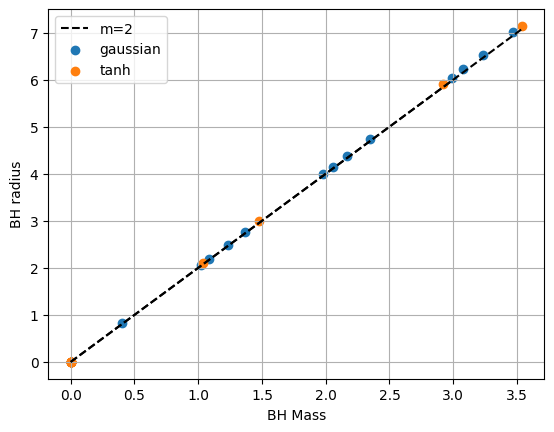

In [9]:
critical_p0 = 1.9154831466382175e-06
critical_radius = 0.078
critical_mass = 0.03925

from scipy.stats import linregress

#Get all radius and p0
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
#Sort by modification date
folder_files.sort(key=getmtime)

tanh_df = pd.DataFrame(columns=['Radius','Mass','phi0'])
gauss_df = pd.DataFrame(columns=['Radius','Mass','phi0'])
for i, file in enumerate(folder_files):
    #Get parameters from the simulation
    mass0 = 1
    BHradius = read_params(file)['BH radius']
    BHmass = read_params(file)['BH mass']
    phi0 = read_params(file)['p0']
    #Add values to the dataframe
    new_row = pd.DataFrame([[BHradius,BHmass,phi0,mass0]],columns=['BHRadius','BHMass','phi0','Mass0'])
    if read_params(file)['fType'] == 'Exponential':
        gauss_df = pd.concat((gauss_df,new_row),ignore_index=True)
    if read_params(file)['fType'] == 'Hyperbolic Tan':
        tanh_df = pd.concat((tanh_df,new_row),ignore_index=True)
#Plot log(delta r0) vs log(delta phi0)
gauss_mass = gauss_df['BHMass'].values
gauss_mass_frac = gauss_df['BHMass'].values/gauss_df['Mass0'].values
gauss_radius = gauss_df['BHRadius'].values
tanh_mass = tanh_df['BHMass'].values
tanh_mass_frac = tanh_df['BHMass'].values/tanh_df['Mass0'].values
tanh_radius = tanh_df['BHRadius'].values

plt.plot((0,gauss_mass[-1]),(0,2*gauss_mass[-1]),'--k',label='m=2')
plt.plot((0,tanh_mass[-1]),(0,2*tanh_mass[-1]),'--k')
plt.scatter(gauss_mass,gauss_radius,label='gaussian')
plt.scatter(tanh_mass,tanh_radius,label='tanh')
plt.ylabel('BH radius')
plt.xlabel('BH Mass')
plt.legend()
plt.grid()
plt.show()

# Fig 1 replica

In [2]:
#Run the simulation

import subprocess
output = subprocess.check_output([".\Collapse.exe", '0', '0.04', '0', '0', '0', '0.01', '100', '21000'], text=True,)
#output = subprocess.check_output([".\Collapse_full.exe", '1', '0.00000016', '0', '0', '0', '50', '11'], text=True,)
print(f"Execution:\n{output}")

Execution:
Total iterations: 21000
Finished, total time: 44s



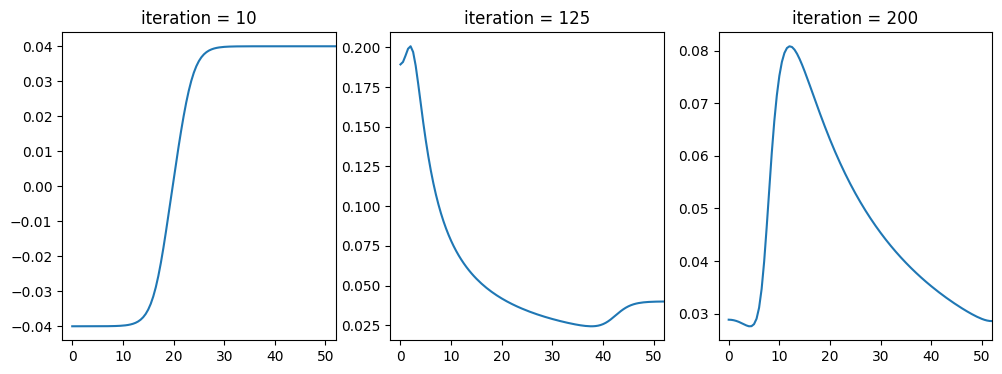

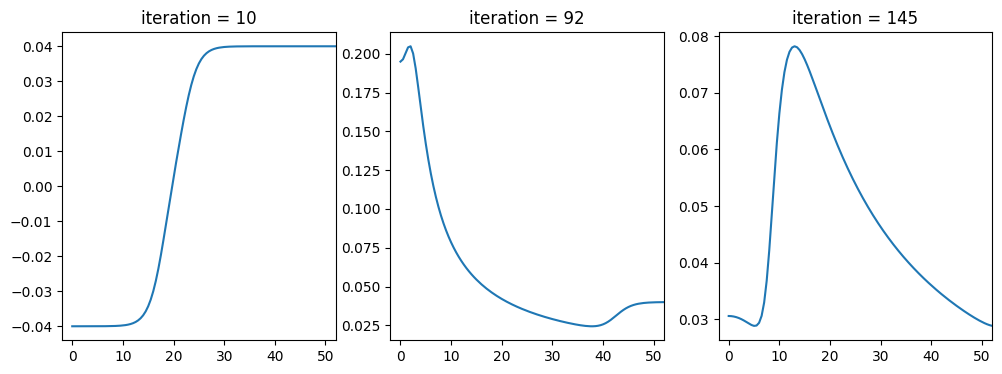

In [12]:
#Plot the phi field at given times

fname = 'Output_213901.dat'
r,f,x,y,a,b,param = read_data(fname)

tanh_times = [10,125,200]
fig, ax = plt.subplots(1,3,figsize=(12,4),dpi=100)
ax[0].plot(r,f[tanh_times[0]])[0]
ax[0].set_xlim(-2,52)
ax[0].set_title(f'iteration = {tanh_times[0]}')
ax[1].plot(r,f[tanh_times[1]])[0]
ax[1].set_xlim(-2,52)
ax[1].set_title(f'iteration = {tanh_times[1]}')
ax[2].plot(r,f[tanh_times[2]])[0]
ax[2].set_xlim(-2,52)
ax[2].set_title(f'iteration = {tanh_times[2]}')
plt.show()


fname = 'Output_214109.dat'
r,f,x,y,a,b,param = read_data(fname)

tanh_times = [10,92,145]
fig, ax = plt.subplots(1,3,figsize=(12,4),dpi=100)
ax[0].plot(r,f[tanh_times[0]])[0]
ax[0].set_xlim(-2,52)
ax[0].set_title(f'iteration = {tanh_times[0]}')
ax[1].plot(r,f[tanh_times[1]])[0]
ax[1].set_xlim(-2,52)
ax[1].set_title(f'iteration = {tanh_times[1]}')
ax[2].plot(r,f[tanh_times[2]])[0]
ax[2].set_xlim(-2,52)
ax[2].set_title(f'iteration = {tanh_times[2]}')
plt.show()

# Critical point 10^-2

In [4]:
#Find critical point
import subprocess
import numpy as np

#Define an initial known subcritical and supercritical parameter
sub_p0   = 3.828125e-06
super_p0 = 3.835937499999999e-06

#How many iterations to make to find the critical point
critical_iterations = 10

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
deltaR = '0.01'
maxR = "50"
iterations = "50000"

for i in range(critical_iterations):
    new_p0 = sub_p0 + (super_p0 - sub_p0)/2
    print(f'Now trying p0 = {new_p0} ...')
    output = subprocess.check_output([".\Collapse.exe",  fType, str(new_p0), r0, d, ko, deltaR, maxR, iterations], text=True,)
    #Read last output and check if it has a non-zero radius
    last_radius = float(read_params()['BH radius'])
    #If BH has formed, save as new supercritical value
    if last_radius > 0.0:
        super_p0 = new_p0
        print('Parameter is supercritical\n')
    #If BH hasn't formed, save as new subcritical value
    elif last_radius == 0.0:
        sub_p0 = new_p0
        print('Parameter is subcritical\n')
print('Critical search result:')
print(f'Highest subcritical value is:  {sub_p0}')
print(f'Lowest supercritical value is: {super_p0}')



Now trying p0 = 3.8320312499999995e-06 ...
Parameter is subcritical

Now trying p0 = 3.833984374999999e-06 ...
Parameter is supercritical

Now trying p0 = 3.8330078125e-06 ...
Parameter is subcritical

Now trying p0 = 3.833496093749999e-06 ...
Parameter is supercritical

Now trying p0 = 3.833251953125e-06 ...
Parameter is subcritical

Now trying p0 = 3.8333740234375e-06 ...
Parameter is supercritical

Now trying p0 = 3.83331298828125e-06 ...
Parameter is supercritical

Now trying p0 = 3.833282470703125e-06 ...
Parameter is subcritical

Now trying p0 = 3.833297729492187e-06 ...
Parameter is supercritical

Now trying p0 = 3.833290100097656e-06 ...
Parameter is subcritical

Critical search result:
Highest subcritical value is:  3.833290100097656e-06
Lowest supercritical value is: 3.833297729492187e-06


In [4]:
#Make a bunch of runs with p0 higher than critical_p0

critical_p0 = 3.833297729492187e-06
critical_radius = 0.25
critical_mass = 0.121770
p0s = np.logspace(np.log10(1.001*critical_p0),np.log10(1.05*critical_p0),20)

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
deltaR = "0.01"
maxR = "50"
iterations = "50000"

for p0 in p0s:
    output = subprocess.check_output([".\Collapse.exe",  fType, str(p0), r0, d, ko, deltaR, maxR, iterations], text=True,)



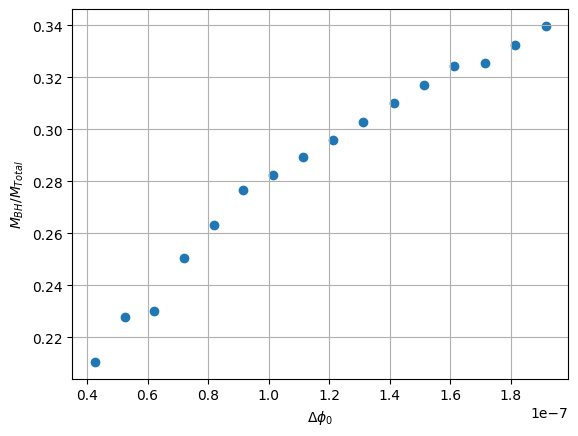

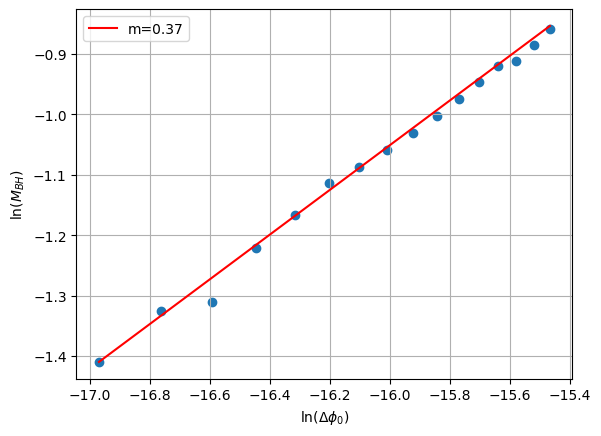

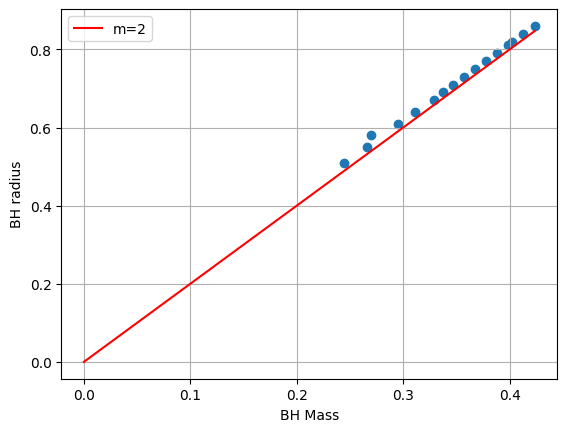

In [6]:
critical_p0 = 3.833297729492187e-06
critical_radius = 0.25
critical_mass = 0.121770

#Get all radius and p0
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
#Sort by modification date
folder_files.sort(key=getmtime)

results_df = pd.DataFrame(columns=['BHRadius','BHMass','phi0','Mass0'])
for i, file in enumerate(folder_files):
    #Get parameters from the simulation
    BHradius = read_params(file)['BH radius']
    BHmass = read_params(file)['BH mass']
    phi0 = read_params(file)['p0']
    #phi0 = p0s[i]
    with open('Mass'+file[6:]) as f:
        mass0 = float(f.readline().split(',')[0]) 
    #Add values to the dataframe
    new_row = pd.DataFrame([[BHradius,BHmass,phi0,mass0]],columns=['BHRadius','BHMass','phi0','Mass0'])
    results_df = pd.concat((results_df,new_row),ignore_index=True)
#Plot log(delta r0) vs log(delta phi0)
mass = results_df['BHMass'].values
mass_frac = results_df['BHMass'].values/results_df['Mass0'].values
radius = results_df['BHRadius'].values
dphi = results_df['phi0'].values-critical_p0
log_dr   = np.log(results_df['BHRadius'].values-critical_radius)
log_dphi = np.log(dphi)
log_mass = np.log(mass)

plt.scatter(dphi,mass_frac)
plt.ylabel('$M_{BH}/M_{Total}$')
plt.xlabel('$\Delta \phi_0$')
plt.grid()
plt.show()

plt.scatter(log_dphi,log_mass)
plt.ylabel('ln($M_{BH}$)')
plt.xlabel('ln($\Delta \phi_0$)')
plt.plot((log_dphi[0],log_dphi[-1]),(log_mass[0],log_mass[0]+0.37*(log_dphi[-1]-log_dphi[0])),'-r',label='m=0.37')
plt.legend()
plt.grid()
plt.show()

plt.scatter(mass,radius)
plt.ylabel('BH radius')
plt.xlabel('BH Mass')
plt.plot((0,mass[-1]),(0,2*mass[-1]),'-r',label='m=2')
plt.legend()
plt.grid()
plt.show()

# Critical point 10^-3

In [14]:
#Find critical point
import subprocess
import numpy as np

#Define an initial known subcritical and supercritical parameter
sub_p0   = 1.9154793153311646e-06
super_p0 = 1.915494580928138e-06

#How many iterations to make to find the critical point
critical_iterations = 10

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
deltaR = '0.001'
maxR = "50"
iterations = "500000"

for i in range(critical_iterations):
    new_p0 = sub_p0 + (super_p0 - sub_p0)/2
    print(f'Now trying p0 = {new_p0} ...')
    output = subprocess.check_output([".\Collapse.exe",  fType, str(new_p0), r0, d, ko, deltaR, maxR, iterations], text=True,)
    #Read last output and check if it has a non-zero radius
    last_radius = float(read_params()['BH radius'])
    #If BH has formed, save as new supercritical value
    if last_radius > 0.0:
        super_p0 = new_p0
        print('Parameter is supercritical\n')
    #If BH hasn't formed, save as new subcritical value
    elif last_radius == 0.0:
        sub_p0 = new_p0
        print('Parameter is subcritical\n')
print('Critical search result:')
print(f'Highest subcritical value is:  {sub_p0}')
print(f'Lowest supercritical value is: {super_p0}')

Now trying p0 = 1.9154869481296513e-06 ...
Parameter is supercritical

Now trying p0 = 1.915483131730408e-06 ...
Parameter is subcritical

Now trying p0 = 1.9154850399300296e-06 ...
Parameter is supercritical

Now trying p0 = 1.915484085830219e-06 ...
Parameter is supercritical

Now trying p0 = 1.9154836087803134e-06 ...
Parameter is supercritical

Now trying p0 = 1.9154833702553607e-06 ...
Parameter is supercritical

Now trying p0 = 1.915483250992884e-06 ...
Parameter is supercritical

Now trying p0 = 1.915483191361646e-06 ...
Parameter is supercritical

Now trying p0 = 1.915483161546027e-06 ...
Parameter is supercritical

Now trying p0 = 1.9154831466382175e-06 ...
Parameter is supercritical

Critical search result:
Highest subcritical value is:  1.915483131730408e-06
Lowest supercritical value is: 1.9154831466382175e-06


In [ ]:
#Make a bunch of runs with p0 higher than critical_p0

critical_p0 = 1.9154831466382175e-06
critical_radius = 0.078
critical_mass = 0.03925
p0s = np.logspace(np.log10(1.001*critical_p0),np.log10(1.01*critical_p0),10)

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
deltaR = "0.001"
maxR = "50"
iterations = "500000"

for p0 in p0s:
    output = subprocess.check_output([".\Collapse.exe",  fType, str(p0), r0, d, ko, deltaR, maxR, iterations], text=True,)

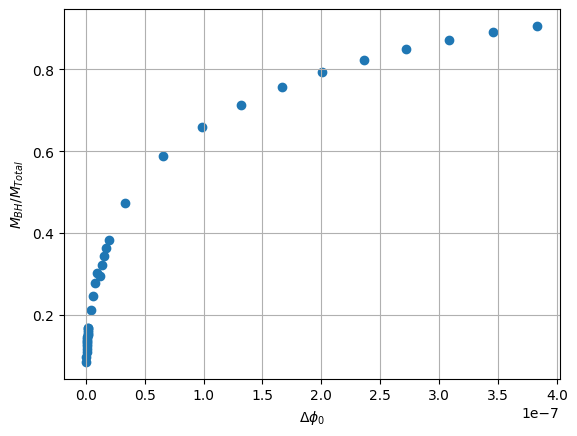

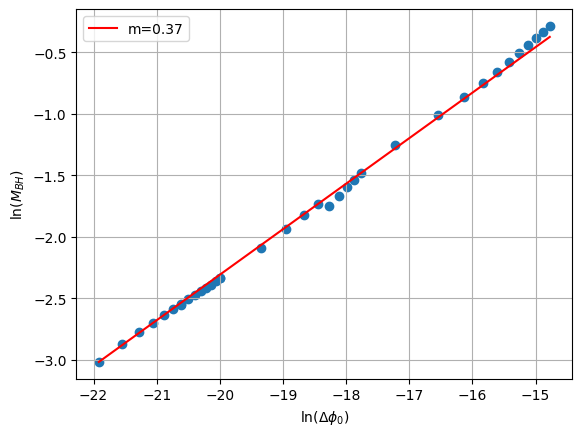

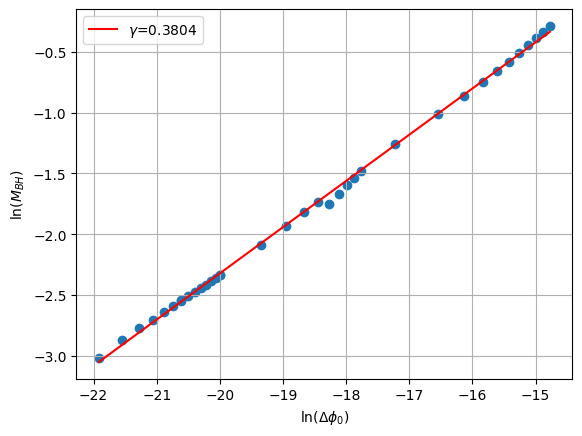

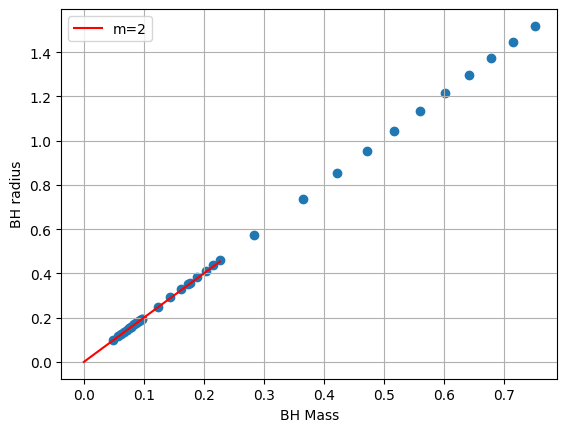

In [7]:
critical_p0 = 1.9154831466382175e-06
critical_radius = 0.078
critical_mass = 0.03925

from scipy.stats import linregress

#Get all radius and p0
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
#Sort by modification date
folder_files.sort(key=getmtime)

results_df = pd.DataFrame(columns=['Radius','Mass','phi0'])
for i, file in enumerate(folder_files):
    with open('Mass'+file[6:]) as f:
        mass0 = float(f.readline().split(',')[0])
    #Get parameters from the simulation
    BHradius = read_params(file)['BH radius']
    BHmass = read_params(file)['BH mass']
    phi0 = read_params(file)['p0']
    #Add values to the dataframe
    new_row = pd.DataFrame([[BHradius,BHmass,phi0,mass0]],columns=['BHRadius','BHMass','phi0','Mass0'])
    results_df = pd.concat((results_df,new_row),ignore_index=True)
#Plot log(delta r0) vs log(delta phi0)
mass = results_df['BHMass'].values
mass_frac = results_df['BHMass'].values/results_df['Mass0'].values
radius = results_df['BHRadius'].values
dphi = results_df['phi0'].values-critical_p0
log_dr   = np.log(results_df['BHRadius'].values-critical_radius)
log_dphi = np.log(dphi)
log_mass = np.log(mass)

plt.scatter(dphi,mass_frac)
plt.ylabel('$M_{BH}/M_{Total}$')
plt.xlabel('$\Delta \phi_0$')
plt.grid()
plt.show()

plt.scatter(log_dphi,log_mass)
plt.ylabel('ln($M_{BH}$)')
plt.xlabel('ln($\Delta \phi_0$)')
logM0 = min(log_mass)
logdphi_i = min(log_dphi)
logdphi_f = max(log_dphi)
plt.plot((logdphi_i,logdphi_f),(logM0,logM0+0.37*(logdphi_f-logdphi_i)),'-r',label='m=0.37')
plt.legend()
plt.grid()
plt.show()

plt.scatter(log_dphi,log_mass)
plt.ylabel('ln($M_{BH}$)')
plt.xlabel('ln($\Delta \phi_0$)')
logM0 = min(log_mass)
logdphi_i = min(log_dphi)
logdphi_f = max(log_dphi)
fit = linregress(log_dphi,log_mass)
plt.plot((logdphi_i,logdphi_f),(fit.intercept+fit.slope*(logdphi_i),fit.intercept+fit.slope*(logdphi_f)),'-r',label=f'$\gamma$={fit.slope:.4}')
plt.legend()
plt.grid()
plt.show()

plt.scatter(mass,radius)
plt.ylabel('BH radius')
plt.xlabel('BH Mass')
plt.plot((0,mass[-1]),(0,2*mass[-1]),'-r',label='m=2')
plt.legend()
plt.grid()
plt.show()